# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK PRIOR TO CHANGING THE SELECTION OF TEST IMAGES PER USE CASE AS PROVIDED HYPER-PARAMETER VALUES CAN BE QUITE SENSITITVE TO EXAMPLE IMAGE YOU ARE USING.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  /content


In [2]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  /content/data/abdominalCT/CTs5.tiff
[  0 127]
There is no tumor


Text(0.5, 1.0, 'Image +contour tumor')

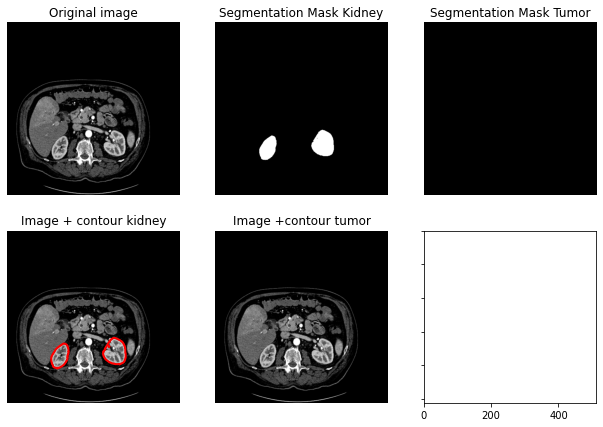

In [3]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['/content/data/brainMRI/MRIs3-seg.png', '/content/data/brainMRI/MRIs2-seg.png', '/content/data/brainMRI/MRIs4-seg.png', '/content/data/brainMRI/MRIs1-seg.png']
Reading image  /content/data/brainMRI/MRIs1.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

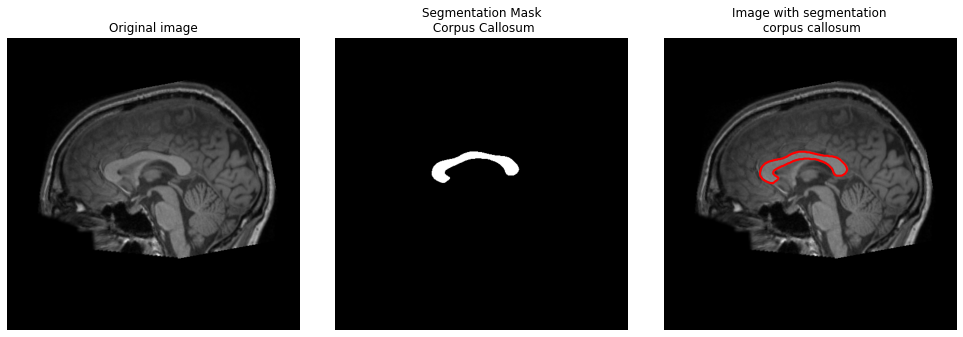

In [4]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


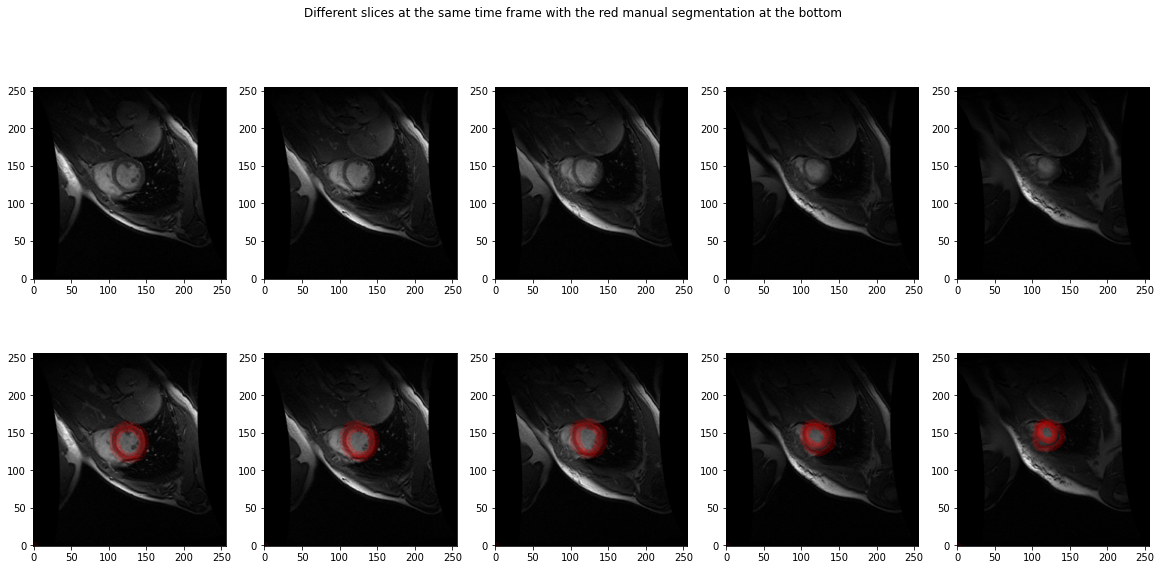

In [5]:
# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 8
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

## For cardiac MRI: how to create a binary mask from the provided contours

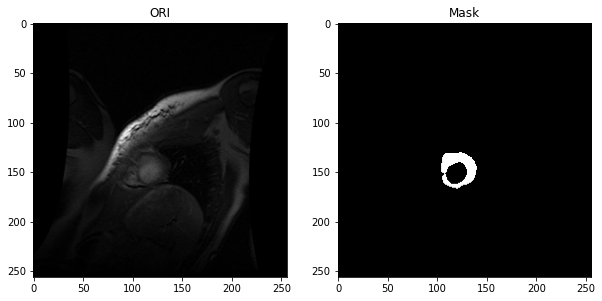

In [6]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]
Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



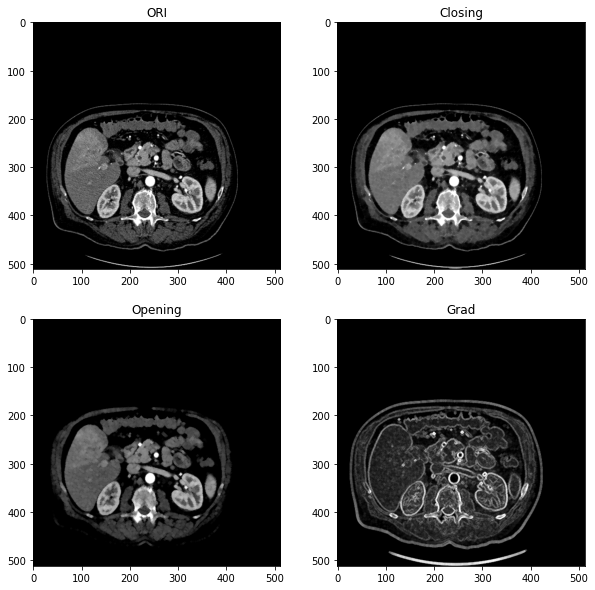

In [7]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

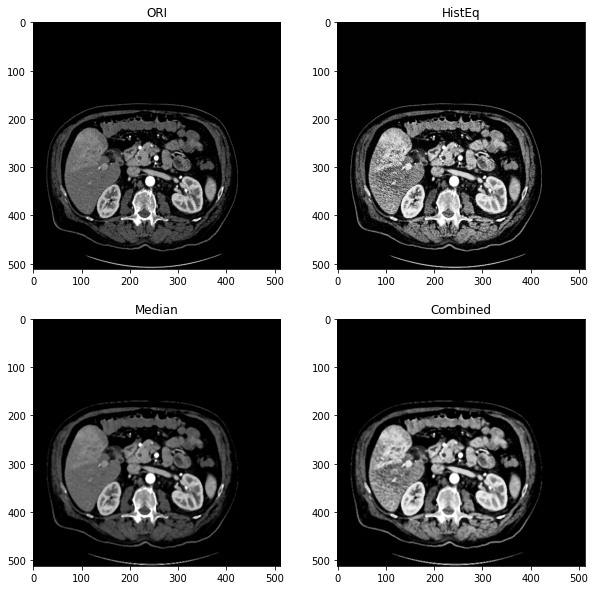

In [8]:
img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");


# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



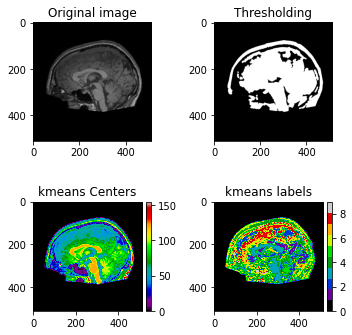

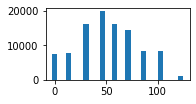

Yout Target_value =  80
Distance of your Target_value to Centers =  [79  6 33 42 49 23  8 76 21 66]
Your selected label (starting with 0)=  1


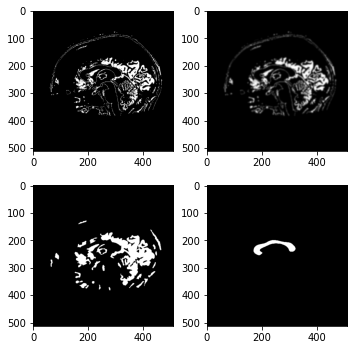

In [9]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

## Extract the structure of interest from your segmentation mask

* CODE TO WRITE ON TWO EXAMPLES FROM SAME USE-CASE <br>
* RETURN A QUALITY METRIC ON THE SEGMENTATION PROVIDED BY YOU COMPARED TO THE PROVIDED GROUND TRUTH


Nous allons d'abord effectué la segmentation sur les IRM de coeur.

Pour évaluer les résultats nous allons utiliser le dice, qui retourne un résultat cohérent avec la qualité de la segmentation car il fait un bon compromis entre TP, TN, FP, FN. La fonction dice présente ci-dessous est tiré de mon projet d'IMA201.

In [10]:
def dice(inputs, target): 

    """
    :param inputs: Masque binaire
    :param target : Masque objectif binaire
    :return : Dice Coefficient (measure of overlap between two masks. 1 indicates a perfect overlap while 0 indicates no overlap)
    """

    num = target.shape[0]   #nombre de lignes
    inputs = inputs.reshape(num, -1)  #On forme des vecteurs colonnes (pour la multiplication terme à terme suivante)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = dice.sum() / num
    return dice

# Cardiac MRI

Commençons par charger les données.

In [398]:
n = data.shape[2] # Nombre d'images
images = [data[:, :, i, 1] for i in range(n)]
cont = [seg[i, 1][:] for i in range(n)]
[cont[i].shape for i in range(n)]

IndexError: ignored

Donc on a 4 'contours' bizarres, on ne va donc pas travailler sur les images correspondantes.

In [397]:
images.pop(n-1)
images.pop(n-2)
images.pop(1)
images.pop(0)
cont.pop(n-1)
cont.pop(n-2)
cont.pop(1)
cont.pop(0)
n = len(images) # Nombre d'images

IndexError: ignored

Ok maintenant c'est niquel, on peut créer les masques avec les contours.


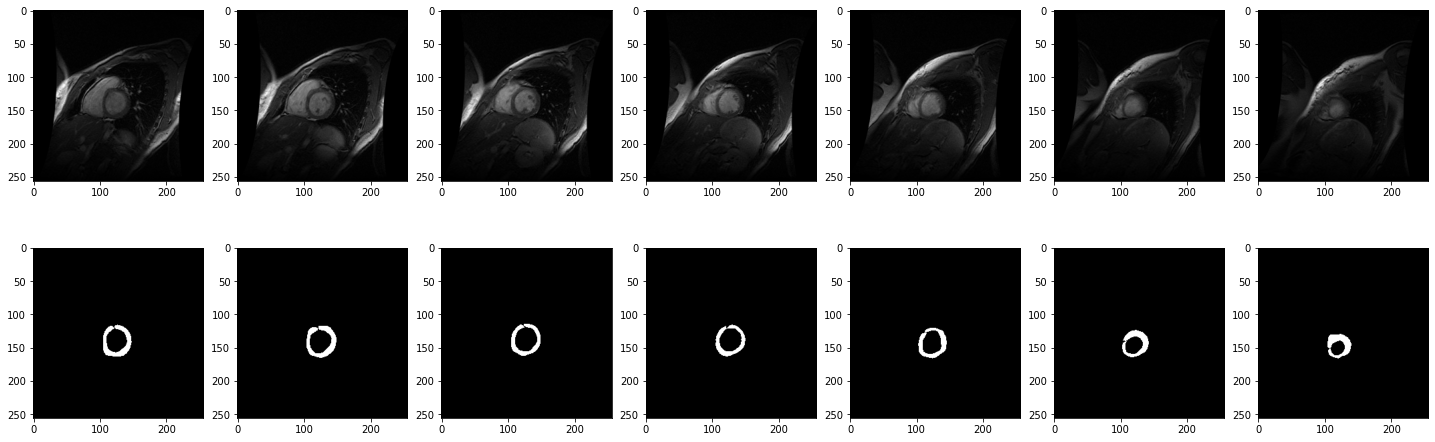

In [15]:
segmentations = []

for i, Cont_cardiac_ex in enumerate(cont):
  Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]
  Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex)
  rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
  Seg_cardiac_ex[rr, cc] = 1
  segmentations.append(Seg_cardiac_ex)

# Plot the data
fig, ax = plt.subplots(2, 7, figsize=(25, 8))
for i in range(7):
  ax[0, i].imshow(images[i], cmap='gray')
  ax[1, i].imshow(segmentations[i], cmap='gray')

L'élément à segmenter se trouve toujours au centre, on va donc rogner les images pour avoir le moins de background possible en conservant l'élément d'intérêt. On fais cela aussi sur les bonnes segmentations pour pouvoir par la suite pouvoir comparer les deux.

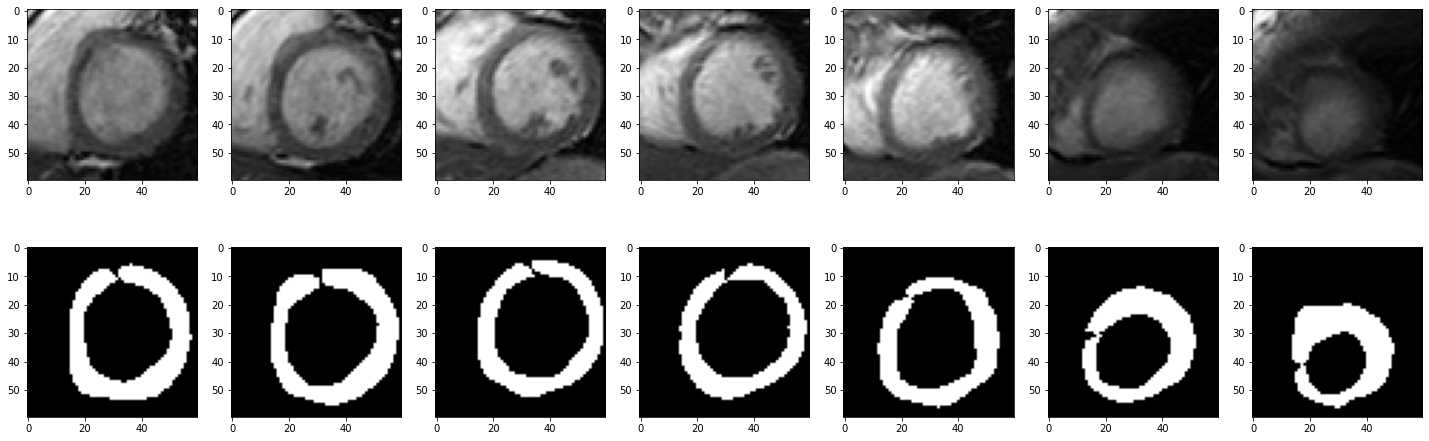

In [16]:
crop_images = []
crop_segmentations = []
for img, seg in zip(images, segmentations):
  crop_images.append(img[110: 170, 90: 150])
  crop_segmentations.append(seg[110: 170, 90: 150])

fig, ax = plt.subplots(2, 7, figsize=(25, 8))
for i in range(7):
  ax[0, i].imshow(crop_images[i], cmap='gray')
  ax[1, i].imshow(crop_segmentations[i], cmap='gray')

On remarque que les images n'ont pas toutes la même range d'intensité. On va donc normaliser cela en rendant l'intensité entre 0 et 1. 

On applique un filtre médian pour débruiter.

Ensuite on souhaite avoir la même luminosité sur toutes les images. On ne va pas faire d'égalisation d'histogramme car cela casserait l'utilisation d'un bon k-means. On va plutôt normaliser à nouveau l'histogramme après avoir détruit seuillé au maximum les 5% des pixels de plus hautes intensités.

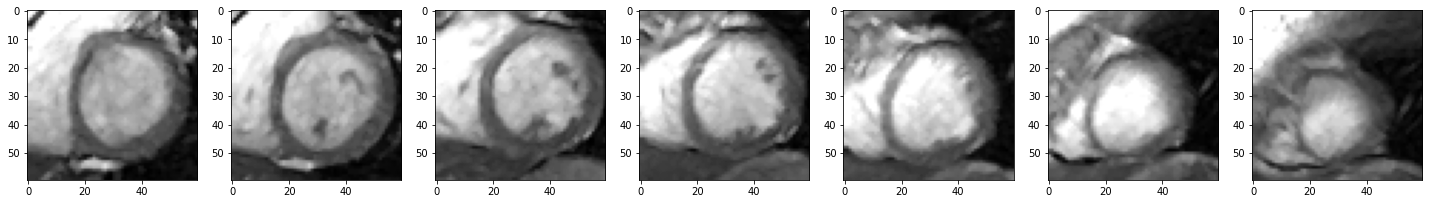

In [206]:
images_pp = [] # images post préprocessing

for img in crop_images:
  # Normalize the images (0 to 1)
  h, w = img.shape[:2]
  a = 1 / (img.max() - img.min())
  b = -a * img.min()
  norm_img = a * img + b
  # Débruitage
  img_median = ndimage.median_filter(norm_img, size=2)
  # On récupère le seuil à partir duquel se trouve 5% des pixels derrière.
  nb, seuils = np.histogram(img_median.flatten(), bins=100) 
  total = h * w #nombre total de pixels
  i = 0
  cumsum = nb[0]
  while cumsum / total < 0.95:
    i += 1
    cumsum += nb[i]
  seuil = seuils[i] 
  # maintenant on normalise l'image en divisant par le seuil et en seuillant à 1 le max
  img_norm = img_median / seuil
  img_norm[img_norm > 1] = 1

  images_pp.append(img_norm)

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(images_pp[i], cmap='gray')

L'exposition de toutes les images sont à peu près les mêmes maintenant. Et on a conservé les pics, notamment celui de l'élément à extraire.

On peut donc regarder l'intensité moyenne de l'élément à extraire sur chacune des images.

In [207]:
[images_pp[i][crop_segmentations[i]].mean() for i in range(len(images))]

[0.710713648108997,
 0.5983188253834081,
 0.47078066151133924,
 0.3165851005981512,
 0.27596082283945106,
 0.47578805104883626,
 0.5975461156517827]

Effectuons donc un k-means autour de ces valeurs et choisissons le label pour lequel l'intensité est la plus proche que l'intensité moyenne dans ces régions.

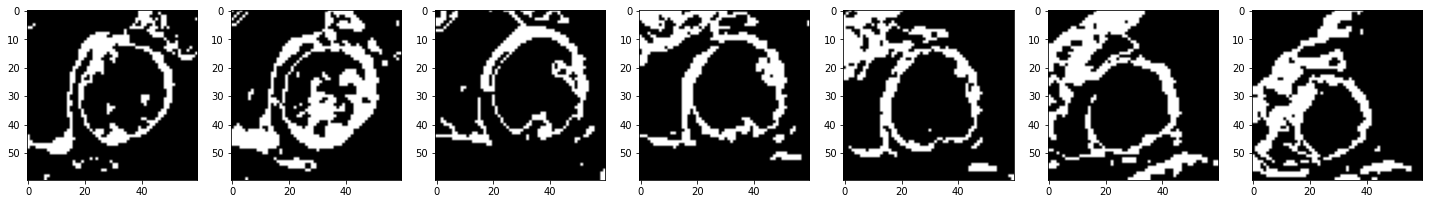

In [213]:
manual_segm = []

for img in images_pp:
  nber_clusters     = 5; Target_value_thresh = 0.50
  Seg_km, Seg_km_labels = my_kmeans(img, nber_clusters)
  Img_label_means = np.empty(nber_clusters)
  for j in range(0,nber_clusters):
      Img_label_mask = Seg_km_labels==j
      Img_label_means[j] = (img[Img_label_mask]).mean()

  Diff = np.absolute(Img_label_means-Target_value_thresh*np.ones(nber_clusters))
  Label_select = np.argmin(Diff)
  manual_segm.append(Seg_km_labels==Label_select)

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(manual_segm[i], cmap='gray')

On élimine à le gros bruit avec un filtre médian.

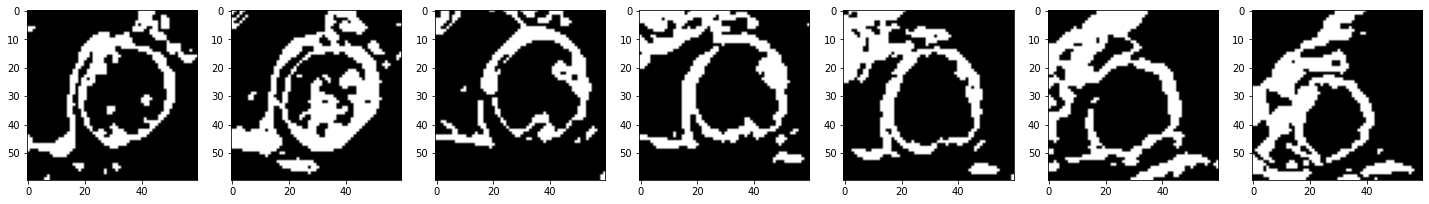

In [214]:
segm_db = []
for seg in manual_segm:
  segm_db.append(ndimage.median_filter(seg, size=2))

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(segm_db[i], cmap='gray')

On conserve la plus grosse composante.

In [225]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

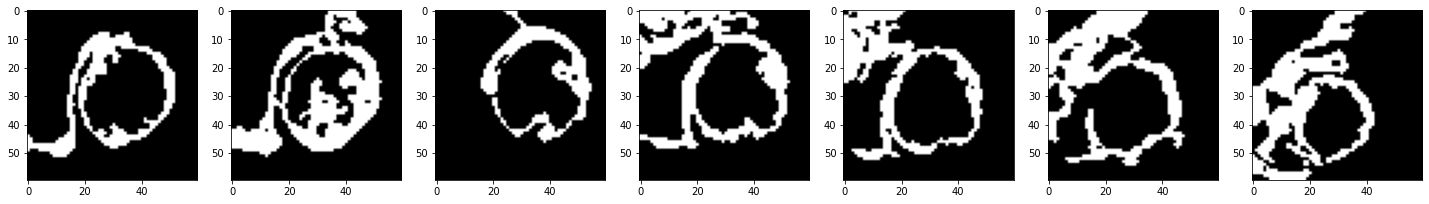

In [235]:
segm_cc = []
for seg in segm_db:
  segm_cc.append(getLargestCC(seg))

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(segm_cc[i], cmap='gray')

On supprime maintenant les gros carrées.

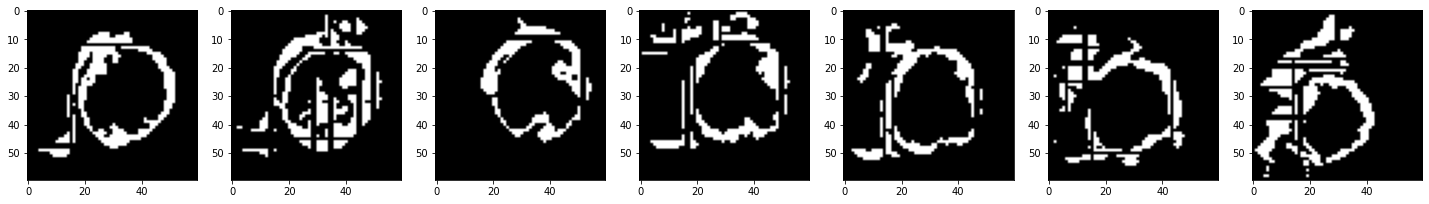

In [345]:
segm_mo = []
for seg in segm_cc:
  # Les masques à enlever
  mask1 = morpho.opening(seg, morpho.rectangle(1, 18))
  mask2 = morpho.opening(seg, morpho.rectangle(18, 1))
  mask = mask1 | mask2
  segm_mo.append(seg & (~mask))

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(segm_mo[i], cmap='gray')

On garde à nouveau la plus grande composante.

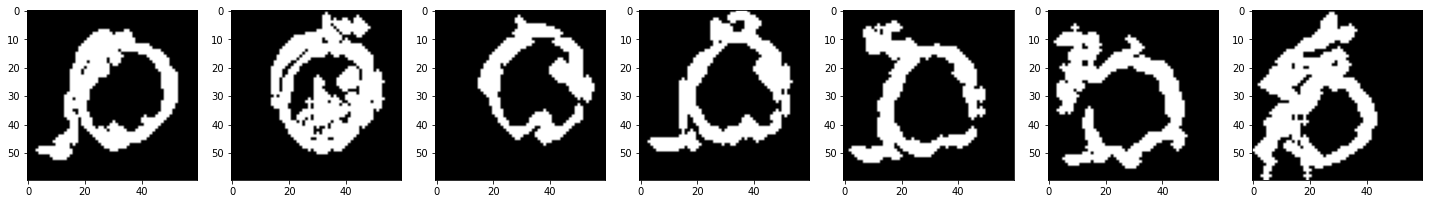

In [346]:
segm_cc2 = []
for seg in segm_mo:
  tmp = morpho.binary_dilation(seg, disk(1))
  segm_cc2.append(getLargestCC(tmp))

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(segm_cc2[i], cmap='gray')

In [347]:
for i in range(n):
  print(dice(segm_cc2[i], crop_segmentations[i]))

0.5852603679837816
0.40142502164613236
0.47024321008855186
0.4739932665986251
0.5111099539397939
0.5827742315634207
0.3634445618287101


Faut prendre en compte que l'image est rognée d'où un dice peu haut. Mais en vrai les résultats sont plutôt acceptables je trouve.

# Brain MRI

On tente d'user de la même technique pour faire ça

We first load the data.

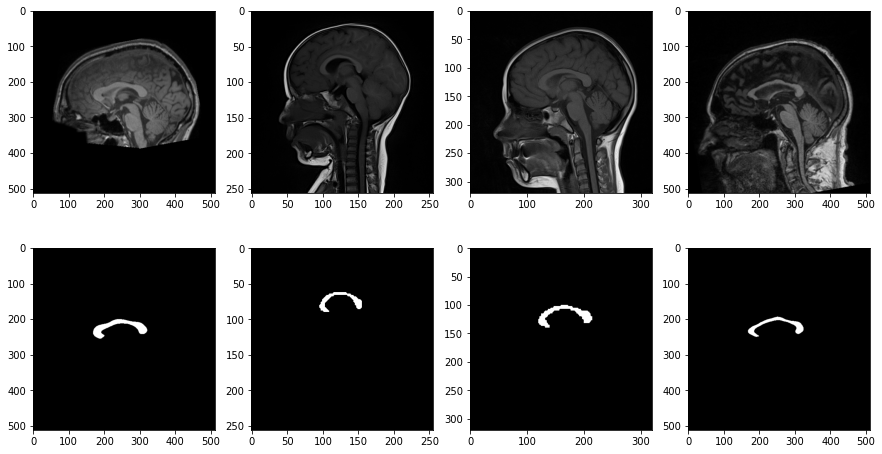

In [363]:
# Load the data
images = [imread(f'/content/data/brainMRI/MRIs{i}.png') for i in range(1, 5)]
segmentations = [imread(f'/content/data/brainMRI/MRIs{i}-seg.png') for i in range(1, 5)]

# Plot the data
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i in range(4):
  ax[0, i].imshow(images[i], cmap='gray')
  ax[1, i].imshow(segmentations[i], cmap='gray')

Au début on rogne

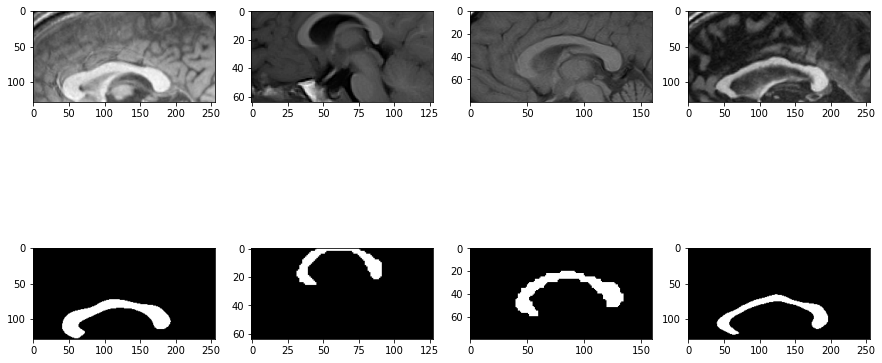

In [365]:
img_crop = []
segm_crop = []
for img, seg in zip(images, segmentations):
  h, w = seg.shape
  img_crop.append(img[h//4: h//2, w//4: -w//4])
  segm_crop.append(seg[h//4: h//2, w//4: -w//4])

fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i in range(4):
  ax[0, i].imshow(img_crop[i], cmap='gray')
  ax[1, i].imshow(segm_crop[i], cmap='gray')

Ensuite on normalise

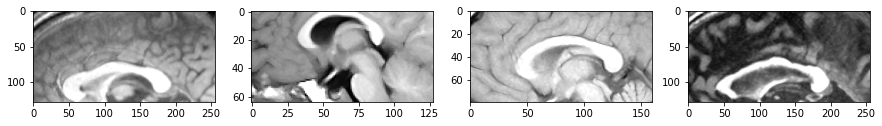

In [373]:
images_pp = [] # images post préprocessing

for img in img_crop:
  # Normalize the images (0 to 1)
  h, w = img.shape[:2]
  a = 1 / (img.max() - img.min())
  b = -a * img.min()
  norm_img = a * img + b
  # Débruitage
  img_median = ndimage.median_filter(norm_img, size=2)
  # On récupère le seuil à partir duquel se trouve 5% des pixels derrière.
  nb, seuils = np.histogram(img_median.flatten(), bins=100) 
  total = h * w #nombre total de pixels
  i = 0
  cumsum = nb[0]
  while cumsum / total < 0.95:
    i += 1
    cumsum += nb[i]
  seuil = seuils[i] 
  # maintenant on normalise l'image en divisant par le seuil et en seuillant à 1 le max
  img_norm = img_median / seuil
  img_norm[img_norm > 1] = 1

  images_pp.append(img_norm)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
  ax[i].imshow(images_pp[i], cmap='gray')

On regarder l'intensité d'interet et on effectue un k means

In [386]:
[images_pp[i][segm_crop[i] > 0].mean() for i in range(len(images))]

[0.9718654160417273,
 0.9210511370487844,
 0.9481169211920072,
 0.9686338575280526]

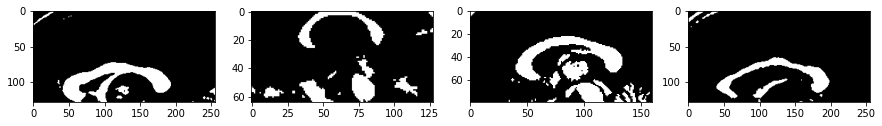

In [388]:
manual_segm = []

for img in images_pp:
  nber_clusters     = 5; Target_value_thresh = 0.94
  Seg_km, Seg_km_labels = my_kmeans(img, nber_clusters)
  Img_label_means = np.empty(nber_clusters)
  for j in range(0,nber_clusters):
      Img_label_mask = Seg_km_labels==j
      Img_label_means[j] = (img[Img_label_mask]).mean()

  Diff = np.absolute(Img_label_means-Target_value_thresh*np.ones(nber_clusters))
  Label_select = np.argmin(Diff)
  manual_segm.append(Seg_km_labels==Label_select)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
  ax[i].imshow(manual_segm[i], cmap='gray')

On garde la plus grande composante

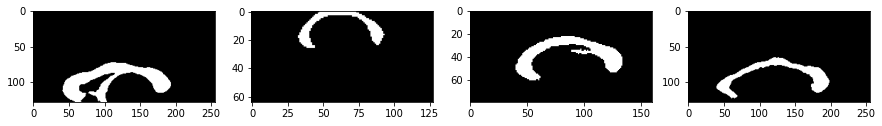

In [391]:
segm_cc = []
for seg in manual_segm:
  segm_cc.append(getLargestCC(seg))

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
  ax[i].imshow(segm_cc[i], cmap='gray')

In [395]:
for i in range(4):
  print(dice(segm_cc[i], segm_crop[i]//255))

0.9240712350402023
0.9380288436582777
0.8999344628583108
0.9604100918102167


Le dice est très bon